In [1]:
import torch
from torchvision.datasets import MNIST
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [5, 5]

In [2]:
train_dataset = MNIST('/train', train=True, download=True, transform=transforms.ToTensor())
test_dataset = MNIST('/test', train=False, download=True, transform=transforms.ToTensor())

train_dataset, dev_dataset = random_split(train_dataset, [int(len(train_dataset) * 0.83), int(len(train_dataset) * 0.17)])

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:10<00:00, 907kB/s] 


Extracting /train/MNIST/raw/train-images-idx3-ubyte.gz to /train/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]


Extracting /train/MNIST/raw/train-labels-idx1-ubyte.gz to /train/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:06<00:00, 243kB/s]


Extracting /train/MNIST/raw/t10k-images-idx3-ubyte.gz to /train/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.10MB/s]


Extracting /train/MNIST/raw/t10k-labels-idx1-ubyte.gz to /train/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:11<00:00, 899kB/s] 


Extracting /test/MNIST/raw/train-images-idx3-ubyte.gz to /test/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]


Extracting /test/MNIST/raw/train-labels-idx1-ubyte.gz to /test/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:06<00:00, 245kB/s]


Extracting /test/MNIST/raw/t10k-images-idx3-ubyte.gz to /test/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 9.32MB/s]

Extracting /test/MNIST/raw/t10k-labels-idx1-ubyte.gz to /test/MNIST/raw



In [3]:
# Define Notebook Constants

total_train_size = len(train_dataset)
total_test_size = len(test_dataset)
total_dev_size = len(dev_dataset)

classes = 10
input_dim = 784

num_clients = 8
rounds = 30
batch_size = 128
epochs_per_client = 3
learning_rate = 2e-2

In [4]:
total_train_size, total_dev_size, total_test_size

(49800, 10200, 10000)

In [5]:
# Define utilities for GPU support

def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader(DataLoader):
        def __init__(self, dl, device):
            self.dl = dl
            self.device = device

        def __iter__(self):
            for batch in self.dl:
                yield to_device(batch, self.device)

        def __len__(self):
            return len(self.dl)

device = get_device()

In [6]:
device

device(type='cuda')

In [7]:
# Define FederatedNet class
class FederatedNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 20, 7)
        self.conv2 = torch.nn.Conv2d(20, 40, 7)
        self.maxpool = torch.nn.MaxPool2d(2, 2)
        self.flatten = torch.nn.Flatten()
        self.linear = torch.nn.Linear(2560, 10)
        self.non_linearity = torch.nn.functional.relu
        self.track_layers = {'conv1': self.conv1, 'conv2': self.conv2, 'linear': self.linear}

    def forward(self, x_batch):
        out = self.conv1(x_batch)
        out = self.non_linearity(out)
        out = self.conv2(out)
        out = self.non_linearity(out)
        out = self.maxpool(out)
        out = self.flatten(out)
        out = self.linear(out)
        return out

    def get_track_layers(self):
        return self.track_layers

    def apply_parameters(self, parameters_dict):
        with torch.no_grad():
            for layer_name in parameters_dict:
                self.track_layers[layer_name].weight.data *= 0
                self.track_layers[layer_name].bias.data *= 0
                self.track_layers[layer_name].weight.data += parameters_dict[layer_name]['weight']
                self.track_layers[layer_name].bias.data += parameters_dict[layer_name]['bias']

    def get_parameters(self):
        parameters_dict = dict()
        for layer_name in self.track_layers:
            parameters_dict[layer_name] = {
                'weight': self.track_layers[layer_name].weight.data,
                'bias': self.track_layers[layer_name].bias.data
            }
        return parameters_dict

    def batch_accuracy(self, outputs, labels):
        with torch.no_grad():
            _, predictions = torch.max(outputs, dim=1)
            return torch.tensor(torch.sum(predictions == labels).item() / len(predictions))

    def _process_batch(self, batch):
        images, labels = batch
        outputs = self(images)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        accuracy = self.batch_accuracy(outputs, labels)
        return (loss, accuracy)

    def fit(self, dataset, epochs, lr, batch_size=128, opt=torch.optim.SGD):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size, shuffle=True), device)
        optimizer = opt(self.parameters(), lr)
        history = []
        for epoch in range(epochs):
            losses = []
            accs = []
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                loss.detach()
                losses.append(loss)
                accs.append(acc)
            avg_loss = torch.stack(losses).mean().item()
            avg_acc = torch.stack(accs).mean().item()
            history.append((avg_loss, avg_acc))
        return history

    def evaluate(self, dataset, batch_size=128):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size), device)
        losses = []
        accs = []
        with torch.no_grad():
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                losses.append(loss)
                accs.append(acc)
        avg_loss = torch.stack(losses).mean().item()
        avg_acc = torch.stack(accs).mean().item()
        return (avg_loss, avg_acc)

In [8]:
# Define Client class
class Client:
    def __init__(self, client_id, dataset):
        self.client_id = client_id
        self.dataset = dataset

    def get_dataset_size(self):
        return len(self.dataset)

    def get_client_id(self):
        return self.client_id

    def train(self, parameters_dict):
        net = to_device(FederatedNet(), device)
        net.apply_parameters(parameters_dict)
        train_history = net.fit(self.dataset, epochs_per_client, learning_rate, batch_size)
        print('{}: Loss = {}, Accuracy = {}'.format(self.client_id, round(train_history[-1][0], 4), round(train_history[-1][1], 4)))
        return net.get_parameters()

In [9]:
# Setup clients

examples_per_client = total_train_size // num_clients
client_datasets = random_split(train_dataset, [min(i + examples_per_client,
           total_train_size) - i for i in range(0, total_train_size, examples_per_client)])
clients = [Client('client_' + str(i), client_datasets[i]) for i in range(num_clients)]

In [10]:
# Start server

global_net = to_device(FederatedNet(), device)
history = []
for i in range(rounds):
    print('Start Round {} ...'.format(i + 1))
    curr_parameters = global_net.get_parameters()
    new_parameters = dict([(layer_name, {'weight': 0, 'bias': 0}) for layer_name in curr_parameters])
    for client in clients:
        client_parameters = client.train(curr_parameters)
        fraction = client.get_dataset_size() / total_train_size
        for layer_name in client_parameters:
            new_parameters[layer_name]['weight'] += fraction * client_parameters[layer_name]['weight']
            new_parameters[layer_name]['bias'] += fraction * client_parameters[layer_name]['bias']
    global_net.apply_parameters(new_parameters)

    train_loss, train_acc = global_net.evaluate(train_dataset)
    dev_loss, dev_acc = global_net.evaluate(dev_dataset)
    print('After round {}, train_loss = {}, dev_loss = {}, dev_acc = {}\n'.format(i + 1, round(train_loss, 4),
            round(dev_loss, 4), round(dev_acc, 4)))
    history.append((train_loss, dev_loss))

Start Round 1 ...
client_0: Loss = 0.4363, Accuracy = 0.8685
client_1: Loss = 0.4607, Accuracy = 0.8621
client_2: Loss = 0.4461, Accuracy = 0.8648
client_3: Loss = 0.4459, Accuracy = 0.8662
client_4: Loss = 0.4464, Accuracy = 0.8661
client_5: Loss = 0.4676, Accuracy = 0.8615
client_6: Loss = 0.4405, Accuracy = 0.8689
client_7: Loss = 0.448, Accuracy = 0.8634
After round 1, train_loss = 0.3838, dev_loss = 0.3857, dev_acc = 0.8901

Start Round 2 ...
client_0: Loss = 0.2801, Accuracy = 0.9177
client_1: Loss = 0.2971, Accuracy = 0.9133
client_2: Loss = 0.2866, Accuracy = 0.9161
client_3: Loss = 0.2885, Accuracy = 0.916
client_4: Loss = 0.2865, Accuracy = 0.9163
client_5: Loss = 0.2884, Accuracy = 0.9182
client_6: Loss = 0.2902, Accuracy = 0.9151
client_7: Loss = 0.2893, Accuracy = 0.917
After round 2, train_loss = 0.265, dev_loss = 0.2681, dev_acc = 0.924

Start Round 3 ...
client_0: Loss = 0.2069, Accuracy = 0.9397
client_1: Loss = 0.2184, Accuracy = 0.9407
client_2: Loss = 0.2076, Accura

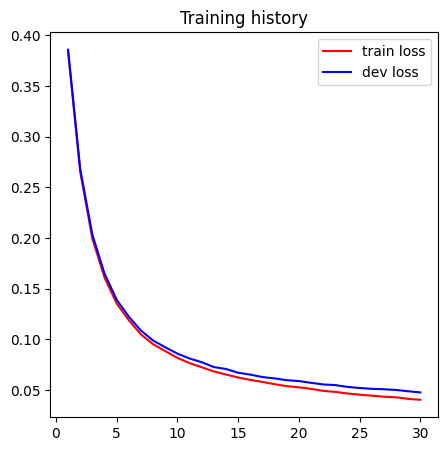

In [11]:
plt.plot([i + 1 for i in range(len(history))], [history[i][0] for i in range(len(history))], color='r', label='train loss')
plt.plot([i + 1 for i in range(len(history))], [history[i][1] for i in range(len(history))], color='b', label='dev loss')
plt.legend()
plt.title('Training history')
plt.show()